# Machine Learning Basics

**Keywords**: Machine Learning, Binary Classifier, Feature Engineering, Feature Selection, Hyperparameter Tuning

I wanted to write a small "hello world" kind of notebook on Machine Learning to add to my collection, but I actually ended up covering a whole lot of the Machine Learning Workflow. If you want to check out something more straight-forward take a look at [this](https://en.wikipedia.org/wiki/To_be_announced) Linear Regression example. Rest assured, this time I'm not working with any house sale price database, however, I am guilty of continuing the over-exploitation of the [Titanic Survivors Kaggle dataset](https://www.kaggle.com/c/titanic). I chose that dataset because this notebook did start out as a simple example, but things escalated quickly. orz

The purpose of this notebook it to have a quick look-up guide of steps and functions regularly used in the Machine Learning workflow. We will do Exploratory Data Analysis, Feature Engineering, Feature and Model Selection[,](https://en.oxforddictionaries.com/explore/what-is-the-oxford-comma/) and Hyperparameter Tuning on the aforementioned Titanic dataset. Our goal is to predict whether a passenger would have survived nor not ([Binary Classification](https://en.wikipedia.org/wiki/Binary_classification)) based on features such as gender and ticket fare.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis

In [8]:
train = pd.read_csv("titanic_data/train.csv")
holdout = pd.read_csv("titanic_data/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data dictionary can give us an idea of what these columns mean

|Column|Description|
|:------:|:------|
|PassengerID | A column added by Kaggle to identify each row and make submissions easier|
|Survived | Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)|
|Pclass | The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)|
|Sex | The passenger's sex|
|Age | The passenger's age in years|
|SibSp | The number of siblings or spouses the passenger had aboard the Titanic|
|Parch | The number of parents or children the passenger had aboard the Titanic|
|Ticket | The passenger's ticket number|
|Fare | The fare the passenger paid|
|Cabin | The passenger's cabin number|
|Embarked | The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)|

Our [domain knowledge](https://en.wikipedia.org/wiki/Women_and_children_first) gives us a starting point as to which variables we might want to analyze more closely: _Age_, _Sex_, and _PClass_ could be good survival predictors.

Let's use a pivot table to see the percentage of survivors of each class for each of the above predictors. The Sex and Class features are categorical variables, so they're pretty straightforward, however, we'll perform a little transformation on the Age column. 

In [3]:
print train["Age"].describe()
print "Missing values on the Age column:" , train["Age"].isna().sum()
print "Unique values on the Age column:" , len(train["Age"].unique())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
Missing values on the Age column: 177
Unique values on the Age column: 89


The age column has a total of 89 unique values. This is because Age is a continous variable. A continous variable can be [dichotomized](https://www.r-bloggers.com/from-continuous-to-categorical/) into a categorical one in order to assign survivability rates to a cohort (age group). In the process, we will also deal with the missing 177 values. 

Any transformations applied to the train set must be applied to the test set as well, otherwise, the model will be trained with certain data dimensionality and scale, yielding parameters that wouldn't match the test data. In other words, we can't train a model to predict survivors based on age group if when we feed it data to predict we're not actually giving it an age group, but a number.

The holdout dataset is what we would make predictions on and submit to Kaggle. I will be applying all the transformations on it as well, but I won't be preparing a subsmission.

In [9]:
def dichotomize(df, col,cut_points,label_names):
    #Deal with the missing values by excluding them from the positive ranges i.e:making them negative. 
    #cut points should include a bin that includes the negative values and label it as Missing 
    df[col] = df[col].fillna(-0.5)
    df[col + "_categories"] = pd.cut(df[col],cut_points,labels=label_names)
    df = df.drop(col, axis = 1)
    return df

In [10]:
label_names = ["Missing", "Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]
cut_points = [-1,0,5,12,18,35,60,100]

train = dichotomize(train, "Age", cut_points, label_names)
holdout = dichotomize(holdout, "Age", cut_points, label_names)

Let's take a look at the age column after transforming it to a categorical variable.  

In [11]:
print train["Age_categories"].describe()
print "Missing values on the Age Categories column:" , train["Age_categories"].isna().sum()
print "Unique values on the Age Categories column:" , len(train["Age_categories"].unique())
print train["Age_categories"].unique()

count             891
unique              7
top       Young Adult
freq              358
Name: Age_categories, dtype: object
Missing values on the Age Categories column: 0
Unique values on the Age Categories column: 7
[Young Adult, Adult, Missing, Infant, Teenager, Child, Senior]
Categories (7, object): [Missing < Infant < Child < Teenager < Young Adult < Adult < Senior]


In [12]:
def plot_pivot(col,ax):
    sns.set()
    sex_pivot = train.pivot_table(index=col,values="Survived")
    #Explicity pass ax.  Unlike other dataframe plots, the bar plot isn't added to the proper subplot.
    sex_pivot.plot.bar(alpha = 0.6, ax=ax, color = "orange")

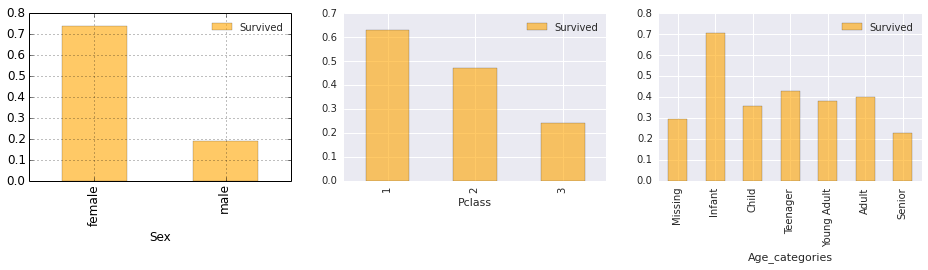

In [13]:
fig = plt.figure(figsize=(16, 3))

ax = fig.add_subplot(1,3,1)
plot_pivot("Sex", ax)

ax = fig.add_subplot(1,3,2)
plot_pivot("Pclass", ax)

ax = fig.add_subplot(1,3,3)
plot_pivot("Age_categories", ax)



As we expected, based the Birkenhead Drill, Women and Children were given priority over the rest of the passengers. At the same time, passengers with a higher status, as inferred from the class they were traveling in, also had a higher survivability rate.

A problem with label encoding is that it assumes higher the categorical value, better the category. For example, PClass certainly has some sort of ordered relationship, but it is not the same as the relationship between the numbers 1, 2, and 3. Pclass 2 isn't worth double what class 1 is.

To deal with this problem, we use [one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). We perform a "binarization" of the category and thus are able to include it in our model.

In [14]:
def one_hot_encode(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1),dummies],axis=1)
    return df

In [16]:
cols = ["Pclass", "Sex", "Age_categories"]

for col in cols:
    train = one_hot_encode(train,col)
    holdout = one_hot_encode(holdout,col)

## Logistic Regression (aka The Bread and Butter)

Now that our important features have been pre-processed, we are ready to train a first model. The first model we will use is called Logistic Regression, which is often the first model you will train when performing classification.

In [18]:
from sklearn.linear_model import LogisticRegression

ignore_columns = ['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

lr = LogisticRegression()
lr.fit(train.drop(ignore_columns, axis =1), train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

First attempt: Complete!  The next step is to find out how accurate our model is, by making predictions.

We split our train dataframe into two to avoid **[overfitting](https://en.wikipedia.org/wiki/Overfitting):**
80% of the observations will make the train set and the remaining 20% will make the test set. Note that we cannot use the holdout dataset for this purpose, as it does not contain a target (Survived?) column. 

In [21]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train.drop(ignore_columns, axis =1), train.Survived, test_size = 0.2)

There are a number of ways to measure the accuracy of machine learning models. In this case, the evaluation section for the Titanic competition on Kaggle tells us that our score calculated as "the percentage of passengers correctly predicted". This is by far the most common form of [accuracy](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models) for binary classification.

In [28]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

accuracy = accuracy_score(test_y, predictions)

print("Model Accuracy:" , '{:.2%}'.format(accuracy))

('Model Accuracy:', '79.33%')


The LR model has an accuracy score of 79.3% when tested against **ONLY** the 20% test set. The problem with machine learning models is that you won’t get to know how well a model performs until you test its performance on an independent data set (the data set which was not used for training the machine learning model). To give us a better understanding of the real performance of our model, we can use a technique called cross validation to train and test our model on different splits of our data.

The most common form of **cross validation** is called [k-fold cross validation](https://magoosh.com/data-science/k-fold-cross-validation/). Here, we split our data in k groups, train on k-1 and test on the remaining one. Repeat for all of the possible splits and then average the scoring metric of all the iterations.

In [31]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(lr, train.drop(ignore_columns, axis =1), train.Survived, cv= 10)
accuracy = np.mean(scores)
print(scores)

print "\nModel Accuracy (Cross Validation):" , '{:.2%}'.format(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]

Model Accuracy (Cross Validation): 80.25%


As it happens, our average accuracy score was 80.25%, which is not far from the 81.0% we got from our simple train/test split, however this will not always be the case, and you should always use cross-validation to make sure the error metrics you are getting from your model are accurate.

There are many things we can do to improve the accuracy of our model. Here are some that we will cover in the next two missions of this course:

**Improving the features:**
Feature Engineering: Create new features from the existing data.
Feature Selection: Select the most relevant features to reduce noise and overfitting.

**Improving the model:**
Model Selection: Try a variety of models to improve performance.
Hyperparameter Optimization: Optimize the settings within each particular machine learning model.

## Feature Preparation, Selection and Engineering

There are a number of features we haven't yet utilized. We can ignore PassengerId, since this is just a column Kaggle have added to identify each passenger and calculate scores. We can also ignore Survived, as this is what we're predicting, as well as the three columns we've already used.

In [16]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.

Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to rescale the data. (These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.)

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.
As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers.
Robust Scaler: Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar: for both features most of the transformed values lie in a [-2, 3] range as seen in the zoomed-in figure. 



Rescaling simply stretches or shrinks the data as needed to be on the same scale, in our case between 0 and 1.

In [17]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())


train.Embarked = train.Embarked.fillna("S")
holdout.Embarked = holdout.Embarked.fillna("S")

train = one_hot_encode(train, "Embarked")
holdout = one_hot_encode(holdout, "Embarked")

old_cols = ["SibSp", "Parch", "Fare"]
scaled_cols = ["SibSp_scaled", "Parch_scaled", "Fare_scaled"]

for old, new in zip(old_cols, scaled_cols):
    train[new] = minmax_scale(train[old])
    holdout[new] = minmax_scale(holdout[old])

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

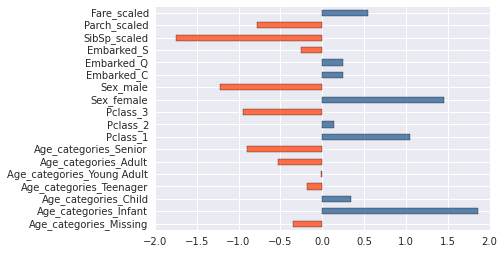

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns],train.Survived)

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index = columns)
positive = pd.Series(coefficients[0] > 0)
positive = positive.map({True: (0.2, 0.4, 0.6, 0.8), False: (1.0, 0.3, 0.1, 0.8)})
feature_importance.plot.barh(color=positive)

The plot we generated in the last screen showed a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value. If you think about it, this makes sense. A feature that indicates strongly whether a passenger died is just as useful as a feature that indicates strongly that a passenger survived, given they are mutually exclusive outcomes.

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

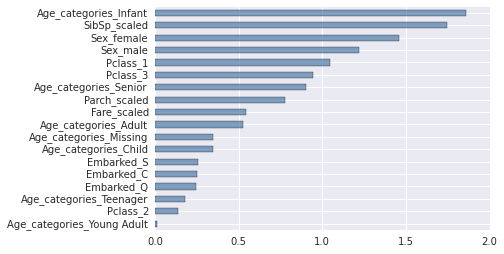

In [19]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh(color=(0.2, 0.4, 0.6, 0.6))
plt.show()

In [20]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv =10)

accuracy = scores.mean()

print(accuracy)

0.8148019521053229


The cross validation score of 81.48% is marginally higher than the cross validation score for the model we created in the previous mission, which had a score of 80.2%.

Hopefully, this improvement will translate to previously unseen data. 

*Submit to Kaggle*

A lot of the gains in accuracy in machine learning come from Feature Engineering. Feature engineering is the practice of creating new features from your existing data.

One common way to engineer a feature is using a technique called binning. Binning is when you take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable.

This can be useful when there are patterns in the data that are non-linear and you're using a linear model (like logistic regression). We actually used binning in the previous mission when we dealt with the Age column, although we didn't use the term.

Let's look at histograms of the Fare column for passengers who died and survived, and see if there are patterns that we can use when creating our bins.

In [21]:
cuts= [0,12,50,100,1000]
labels = ["0-12", "12-50", "50-100", "100+"]
train = dichotomize(train, "Fare", cuts,labels)
holdout = dichotomize(holdout,"Fare", cuts, labels)


train = one_hot_encode(train, "Fare_categories")
holdout = one_hot_encode(holdout, "Fare_categories")

Another way to engineer features is by extracting data from text columns. Earlier, we decided that the Name and Cabin columns weren't useful by themselves, but what if there is some data there we could extract? 

While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us.

Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types:

Mr
Mrs
Master
Miss
Officer
Royalty

We can use the Series.str.extract method and regex fu to extract the title from each name and then use the Series.map() method and a predefined dictionary to simplify the titles.

In [22]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train = train.drop("Name", axis=1)
holdout = holdout.drop("Name", axis=1)

train["Cabin_type"] = train.Cabin.str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout.Cabin.str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

train = train.drop("Cabin", axis=1)
holdout = holdout.drop("Cabin", axis=1)

train = one_hot_encode(train, "Title")
holdout = one_hot_encode(holdout, "Title")

train = one_hot_encode(train, "Cabin_type")
holdout = one_hot_encode(holdout, "Cabin_type")

We now have 34 possible feature columns we can use to train our model. One thing to be aware of as you start to add more features is a concept called collinearity. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that your model will overfit - you may get great results on your test data set, but then the model performs worse on unseen data (like the holdout set).

One easy way to understand collinearity is with a simple binary variable like the Sex column in our dataset. Every passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'.

As a result, when we created our two dummy columns from the categorical Sex column, we've actually created two columns with identical data in them. This will happen whenever we create dummy columns, and is called the dummy variable trap. The easy solution is to choose one column to drop any time you make dummy columns.

Collinearity can happen in other places, too. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap. 

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


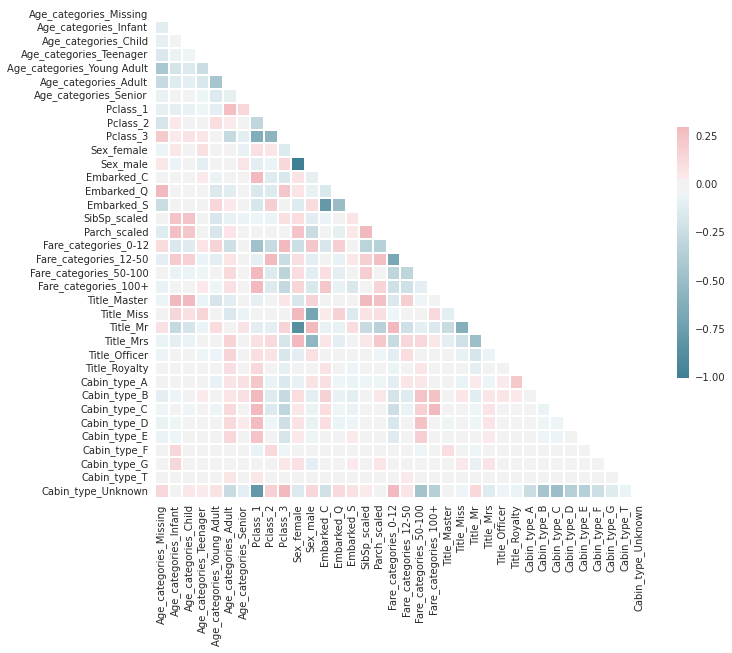

In [23]:
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

Pclass_2
Age_categories_Teenager
Fare_categories_12-50
Title_Master
Cabin_type_A
In an earlier step, we manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation.

The RFECV class starts by training a model using all of your features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

Like the LogisticRegression class, RFECV must first be instantiated and then fit. The first parameter when creating the RFECV object must be an estimator, and we need to use the cv parameter to specific the number of folds for cross-validation.

from sklearn.feature_selection import RFECV
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
Once the RFECV object has been fit, we can use the RFECV.support_ attribute to access a boolean mask of True and False values which we can use to generate a list of optimized columns:

optimized_columns = all_X.columns[selector.support_]


In [24]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr, cv=10)

selector.fit(all_X, all_y)

optimized_columns = all_X.columns[selector.support_]

print(optimized_columns)


Index([u'SibSp_scaled', u'Title_Mr', u'Title_Officer', u'Cabin_type_Unknown'], dtype='object')


In [25]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)

accuracy = scores.mean()
print(accuracy)

0.8226549199863807


This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model

## Model Selection and Tuning

We're going to train our models using all the columns in the train dataframe. This will cause a small amount of overfitting due to collinearity (as we discussed in the previous mission), but having more features will allow us to more thoroughly compare algorithms.

So we have something to compare to, we're going to train a logistic regression model like in the previous two missions. We'll use cross validation to get a baseline score.

In [32]:
all_X = train.drop(['Survived','PassengerId', "Ticket","SibSp", "Parch"],axis=1)
all_y = train['Survived']


lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy_lr = scores.mean()
print(accuracy_lr)

0.823891442515038


In the previous mission, we worked to optimize our predictions by creating and selecting the features used to train our model. The other half of the optimization puzzle is to optimize the model itself— or more specifically, the algorithm used to train our model.

So far, we've been using the logistic regression algorithm to train our models, however there are hundreds of different machine learning algorithms from which we can choose. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data— in this case our Kaggle competition.

The process of selecting the algorithm which gives the best predictions for your data is called model selection.

In this mission, we're going work with two new algorithms: k-nearest neighbors and random forests.



The k-nearest neighbors algorithm finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
scores = cross_val_score(knn, all_X, all_y, cv =10)
scores.mean()

0.8026183180115766

Besides pure model selection, we can vary the settings of each model— for instance the value of k in our k-nearest neighbors model. This is called hyperparameter optimization.

In [44]:
knn_scores = []
for i in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, all_X, all_y, cv = 10)
    knn_scores.append(scores.mean())

0.8261136647372602


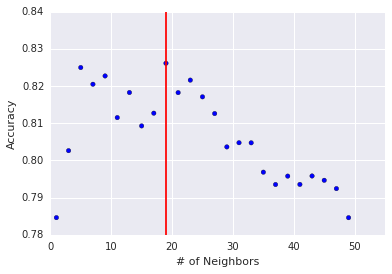

In [64]:
sns.set()
plt.scatter(range(1,50,2), knn_scores)
plt.xlim(0,55)
plt.ylabel("Accuracy")
plt.xlabel("# of Neighbors")
plt.axvline(c="red",x=knn_scores.index(max(knn_scores))*2+1  )
print(max(knn_scores))

Looking at our plot from the previous screen we can see that a k value of 19 gave us our best score of 82.4%, identical to our Logistic Regression.

In our previous attempt we only tuned the number of neighbors parameter of knn. Let's use the Grid Search Library to explore several hyperparameters at the same time.

In [69]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn,param_grid = hyperparameters,cv = 10)

grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}
0.8282828282828283


Let's try another algorithm called random forests. Random forests is a specific type of decision tree algorithm. Decision tree algorithms attempt to build the most efficient decision tree based on the training data, and then use that tree to make future predictions.

In [73]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y,cv=10)
scores.mean()

0.8125669617523551

In [74]:
hyperparameters = {"criterion":["entropy" , "gini"],
"max_depth" : [5,10],
"max_features": ["log2","sqrt"],
"min_samples_leaf":  [1,5],
"min_samples_split": [3,5],
"n_estimators": [6,9]}

grid = GridSearchCV(clf,param_grid = hyperparameters,cv = 10)

grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'min_samples_leaf': 1, 'n_estimators': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10}
0.8406285072951739


In [28]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df,"Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df,"Title")
    df = create_dummies(df,"Cabin_type")
    df = create_dummies(df,"Sex")
    return df

In [29]:
train = pre_process(train)
holdout = pre_process(holdout)

NameError: global name 'process_missing' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
train[["SibSp","Parch"]].describe()

In [ ]:
train.SibSp.value_counts()

In [ ]:
train.Parch.value_counts()

In [ ]:
np.round(pd.pivot_table(train, values='Survived', index='SibSp',  columns='Parch'),2)
#.apply(round,args=[2])

In [ ]:
train["family_size"] = train.SibSp + train.Parch

In [ ]:
train.pivot_table(index='family_size',values="Survived")

In [ ]:
pivot = train.pivot_table(index="family_size",values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1), alpha = 0.7)
plt.axhspan(.3, .6, alpha=0.1, color='red')
plt.show()

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1,2,1)
ax.set_title("SibSp")
train.SibSp.plot.hist(alpha=0.5)

ax = fig.add_subplot(1,2,2)
ax.set_title("Parch")
train.Parch.plot.hist(alpha=0.5)

In [ ]:
train[["SibSp","Parch"]].plot.hist(alpha= 0.25,bins=8)

## Feature Engineering

we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

1 if the passenger has zero family members onboard
0 if the passenger has one or more family members onboard

In [ ]:
def is_alone(df):
    df["isalone"] = df["family_size"]  > 1
    return df

In [ ]:
train = is_alone(train)
holdout["family_size"] = holdout.SibSp + holdout.Parch
holdout = is_alone(holdout)

## Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    X = df.drop(["Survived","PassengerId"],axis=1)
    y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(X,y)
    
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

## Model Selection / Hyperparameter Tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)